#**Step 1: Install All the Required Packages**

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 datasets
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.0 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import re
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

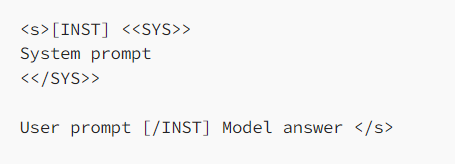

#**We will use a testing dataset that follows Llama 2 template.**

- Dataset: https://huggingface.co/datasets/Amod/mental_health_counseling_conversations

#**Step 3: Load a llama-2-7b-chat-hf model (chat model)**

We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type.

In [ ]:
# The model from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

1. We configure bitsandbytes for 4-bit quantization.


2. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.

In [ ]:
# Load tokenizer and model
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

#**Step 4: Use the text generation pipeline to ask questions like “My mood recently has been very low, I do not feel like getting out of my bed.” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "My mood recently has been very low, I do not feel like getting out of my bed."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] My mood recently has been very low, I do not feel like getting out of my bed. [/INST]  Sorry to hear that you're feeling low and struggling to get out of bed. It's important to remember that you're not alone, and there are many resources available to help you manage your mood and improve your overall well-being. Here are some suggestions that may help:

1. Practice self-care: Take care of your physical and emotional needs by getting enough sleep, eating a healthy diet, and engaging in activities that bring you joy and relaxation.
2. Reach out for support: Talk to a trusted friend, family member, or mental health professional about how you're feeling. They can offer emotional support, provide new perspectives, and help you develop a plan to manage your low mood.
3. Stay active: While it


#**Step 5: Evaluate model responses against test set using BLEU Score**

In [ ]:
# Load the test dataset
dataset = load_dataset('Amod/mental_health_counseling_conversations')

# Select the entries for testing
test_samples = dataset['train'].select(range(2000,2500))

# Function to format the dataset entries
def format_entry(entry):
  # Define the system prompt
    system_prompt = ("<<SYS>> You are a helpful and joyous mental therapy assistant. Always answer as helpfully "
                       "and cheerfully as possible, while being safe. Your answers should not include any harmful, "
                       "unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your "
                       "responses are socially unbiased and positive in nature. If a question does not make any sense, "
                       "or is not factually coherent, explain why instead of answering something not correct. If you "
                       "don't know the answer to a question, please don't share false information. <</SYS>")

    formatted = f"{system_prompt} <s>[INST] {entry['Context']} [/INST]"
    return {'Formatted': formatted}

# Apply the formatting function to the dataset
processed_dataset = test_samples.map(format_entry)

In [ ]:
device = "cuda"

# Function to generate a response
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=250
        # max_new_tokens=100  # Allow 100 new tokens beyond the input
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# def generate_response(prompt, num_beams=5, temperature=0.9, top_k=50, top_p=0.95):
#     inputs = tokenizer(prompt, return_tensors="pt")
#     input_ids = inputs['input_ids'].to(device)
#     attention_mask = inputs['attention_mask'].to(device)

#     # Adjusting model.generate to use beam search with sampling parameters
#     outputs = model.generate(
#         input_ids=input_ids,
#         attention_mask=attention_mask,
#         max_length=250,
#         num_beams=num_beams,  # Number of beams for beam search
#         temperature=temperature,  # Adds randomness to the generation process
#         top_k=top_k,  # Limits the number of highest probability tokens to consider
#         top_p=top_p,  # Nucleus sampling: considers the smallest set of tokens whose cumulative probability exceeds the threshold top_p
#         do_sample=True,  # Enables stochastic beam search
#         num_return_sequences=1  # Optionally generate more than one sequence
#     )
#     response = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return response

# Generate responses and store them in a list
generated_responses = [generate_response(sample['Formatted']) for sample in processed_dataset]

# Add generated responses to the dataset
processed_dataset = processed_dataset.add_column("generated_response", generated_responses)

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [ ]:
# -*- coding: utf-8 -*-
"""BLEUScore.py

This code takes an input output_tokens and reference_tokens
and calculates BLEU score based on 4-gram
"""


from transformers import PreTrainedTokenizerFast


def BleuScore(output_tokens, reference_tokens):

    output_uni_dict = {}
    output_bi_dict = {}
    output_tri_dict = {}
    output_four_dict = {}

    bi = []
    tri = []
    four = []


    for i in range(len(output_tokens)):
        if len(bi) == 2:
            bi = bi[1:]
        if len(tri) == 3:
            tri = tri[1:]
        if len(four) == 4:
            four = four[1:]

        bi.append(output_tokens[i])
        tri.append(output_tokens[i])
        four.append(output_tokens[i])

        output_uni_dict[output_tokens[i]] = output_uni_dict.get(output_tokens[i], 0) + 1

        if i > 0:
            bi_key = tuple(bi)
            output_bi_dict[bi_key] = output_bi_dict.get(bi_key, 0) + 1

        if i > 1:
            tri_key = tuple(tri)
            output_tri_dict[tri_key] = output_tri_dict.get(tri_key, 0) + 1
        if i > 2:
            four_key = tuple(four)
            output_four_dict[four_key] = output_four_dict.get(four_key, 0) + 1

    reference_uni_dict = {}
    reference_bi_dict = {}
    reference_tri_dict = {}
    reference_four_dict = {}

    bi = []
    tri = []
    four = []


    for i in range(len(reference_tokens)):
        if len(bi) == 2:
            bi = bi[1:]
        if len(tri) == 3:
            tri = tri[1:]
        if len(four) == 4:
            four = four[1:]

        bi.append(reference_tokens[i])
        tri.append(reference_tokens[i])
        four.append(reference_tokens[i])

        reference_uni_dict[reference_tokens[i]] = reference_uni_dict.get(reference_tokens[i], 0) + 1

        if i > 0:
            bi_key = tuple(bi)
            reference_bi_dict[bi_key] = reference_bi_dict.get(bi_key, 0) + 1

        if i > 1:
            tri_key = tuple(tri)
            reference_tri_dict[tri_key] = reference_tri_dict.get(tri_key, 0) + 1
        if i > 2:
            four_key = tuple(four)
            reference_four_dict[four_key] = reference_four_dict.get(four_key, 0) + 1

        uni_match = 1
        for key, value in output_uni_dict.items():
            if key in reference_uni_dict:
                uni_match += (value * reference_uni_dict[key])

        bi_match = 1
        for key, value in output_bi_dict.items():
            if key in reference_bi_dict:
                bi_match += (value * reference_bi_dict[key])

        tri_match = 1
        for key, value in output_tri_dict.items():
            if key in reference_tri_dict:
                tri_match += (value * reference_tri_dict[key])

        four_match = 1
        for key, value in output_four_dict.items():
            if key in reference_four_dict:
                quad_match += (value * reference_four_dict[key])




    return min(1, len(output_tokens) / len(reference_tokens)) * (uni_match/ (len(output_tokens))) ** 0.25 * (bi_match/ (len(output_tokens) - 1)) ** 0.25 * (tri_match/ (len(output_tokens) - 2)) ** 0.25 * (four_match/ (len(output_tokens) - 3)) ** 0.25

In [ ]:
def tokenize(text, tokenizer):
    # This function will return token IDs, which are used for BLEU calculation
    encoded_input = tokenizer(text, return_tensors='pt')
    return encoded_input['input_ids'][0].tolist()  # Get the list of token IDs

# Compute BLEU scores
bleu_scores = []
for sample in processed_dataset:
    output_tokens = tokenize(sample['generated_response'], tokenizer)
    reference_tokens = tokenize(sample['Response'], tokenizer)
    score = BleuScore(output_tokens, reference_tokens)
    bleu_scores.append(score)

bleu_score_str = '\n'.join(map(str, bleu_scores))

with open("VANILLA_BLEU.txt", "w") as file:
  file.write(bleu_scores_str)

# Calculate average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score}")

Average BLEU Score: 0.32842105263157895
